# Проект. Аналитика в авиакомпании
## Глава 0. Входные данные
Российская авиакомпания F9 выполняет внутренние пассажирские перевозки. Важно понять предпочтения пользователей, покупающих билеты на разные направления.

Предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

Инструкция по выполнению проекта:  
1) Провести исследовательский анализ данных средствами SQL.  
2) Соберать данные для анализа из базы.  
3) Проанализировать данные средствами Python.

### Описание данных
В вашем распоряжении база данных об авиаперевозках.

Таблица `airports` — информация об аэропортах:  
**airport_code** — трёхбуквенный код аэропорта  
**airport_name** — название аэропорта  
**city** — город  
**timezone** — временная зона   

Таблица `aircrafts` — информация о самолётах:  
**aircraft_code** — код модели самолёта  
**model** — модель самолёта  
**range** — дальность полёта   

Таблица `tickets` — информация о билетах:  
**ticket_no** — уникальный номер билета  
**passenger_id**— персональный идентификатор пассажира  
**passenger_name** — имя и фамилия пассажира  

Таблица `flights` — информация о рейсах:  
**flight_id** — уникальный идентификатор рейса  
**departure_airport** — аэропорт вылета  
**departure_time** — дата и время вылета  
**arrival_airport** — аэропорт прилёта  
**arrival_time** — дата и время прилёта  
**aircraft_code** — id самолёта  

Таблица `ticket_flights` — стыковая таблица «рейсы-билеты»  
**ticket_no** — номер билета  
**flight_id** — идентификатор рейса  

Таблица `festivals` — информация о фестивалях  
**festival_id** — уникальный номер фестиваля  
**festival_date** — дата проведения фестиваля  
**festival_city** — город проведения фестиваля  
**festival_name** — название фестиваля  


Пояснение: В базе данных нет прямой связи между таблицами `airports` и `festivals`, а также `festivals` и `flights`. Но вы можете писать JOIN и связывать эти таблицы по городу проведения фестиваля (festival_city) и городу аэропорта (city). Потребуется некоторое преобразование дат в `flights`, и тогда эту таблицу также можно будет связать по дате проведения фестиваля (festival_date) в запросах с JOIN.

## Шаг 1. Работа с базой
Менеджер авиаперевозчика готовит исследование. Он хочет выявить связь между числом полётов, типом самолётов и календарём музыкальных фестивалей. Помогите ему получить необходимые данные.

**Задача 1**. Найдите количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года. Назовите получившееся поле flights_amount и выведите его. Также напечатайте на экране поле model. Столбцы в таблице должны быть выведены в следующем порядке:
- model
- flights_amount

```sql
SELECT 
    model,
    COUNT(model) AS flights_amount
FROM 
    flights   
INNER JOIN aircrafts ON aircrafts.AIRCRAFT_CODE = flights.AIRCRAFT_CODE
WHERE
    EXTRACT(MONTH FROM flights.DEPARTURE_TIME) = 9
GROUP BY
    model
```

**Задача 2.** Посчитайте количество отправленных рейсов по всем моделям самолётов Boeing и Airbus в сентябре. Назовите получившуюся переменную flights_amount и выведите её. 

```sql
SELECT
    COUNT(*) AS flights_amount 
    
FROM 
    flights   
INNER JOIN aircrafts ON aircrafts.AIRCRAFT_CODE = flights.AIRCRAFT_CODE
WHERE
    (model LIKE '%Airbus%' OR model LIKE '%Boeing%') AND
    EXTRACT(MONTH FROM DEPARTURE_TIME) = 9
```

**Задача 3.** Посчитайте среднее количество прибывающих рейсов в день для каждого города за август 2018 года. Назовите получившееся поле average_flights, вместе с ним выведите столбец city.

```sql
SELECT
    city,
    COUNT(city) / 
    COUNT(DISTINCT DATE_TRUNC('day', ARRIVAL_TIME)) :: real AS average_flights    
FROM 
    (SELECT
         *
     FROM   
         flights   
     INNER JOIN airports ON airports.AIRPORT_CODE = flights.ARRIVAL_AIRPORT
     WHERE
        EXTRACT(MONTH FROM flights.ARRIVAL_TIME) = 8) AS SUBD
GROUP BY
    city
```

**Задача 4.** 
Установите фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. Выведите название фестиваля festival_name и номер недели festival_week.

```sql
SELECT
    festival_name,
    EXTRACT('week' FROM festival_date) AS festival_week 
FROM
    (SELECT
        *
    FROM 
        festivals
    WHERE
        festival_city = 'Москва') AS SUBD

WHERE
    festival_date BETWEEN '2018-07-23' AND '2018-09-30'
```

**Задача 5.** 
Для каждой недели с 23 июля по 30 сентября 2018 года посчитайте количество приобретённых билетов в Москву. Номер недели назовите week_number, количество билетов — ticket_amount. Вставьте результат в первую часть составного запроса в прекоде.  

Ваш запрос соединится с запросом из предыдущей задачи оператором `LEFT JOIN`. Он работает так же, как и `INNER JOIN`. Но в ячейках с неделями, в которые фестивали не проходили, будут значения `nan`.  

Вы получите таблицу с такими столбцами:
week_number — номер недели из вашего запроса;
- ticket_amount — количество купленных за неделю билетов;
- festival_week — номер недели из предыдущего запроса. Будет равен nan, если фестиваля в эту неделю не было.
- festival_name — название фестиваля. Будет равен nan, если фестиваля в эту неделю не было.

```sql
SELECT 
	T.week_number,
	T.ticket_amount,
	T.festival_week,
	T.festival_name
FROM 
(
(
  SELECT
    EXTRACT ('week' FROM ARRIVAL_TIME) AS week_number,
    COUNT(TICKET_NO) AS ticket_amount
FROM
    (SELECT
       *
    FROM
        flights
    INNER JOIN airports ON airports.airport_code  = flights.arrival_airport  
    WHERE
        CITY = 'Москва'
        AND CAST(flights.ARRIVAL_TIME AS date) BETWEEN '2018-07-23' AND '2018-09-30') AS SUBD

INNER JOIN ticket_flights ON ticket_flights.flight_id  = SUBD.flight_id
GROUP BY week_number
) t
LEFT JOIN 
(SELECT 		
		festival_name,	
		EXTRACT (week FROM festivals.festival_date) AS festival_week
	FROM 
		festivals
	WHERE
		festival_city = 'Москва'
	  AND CAST(festivals.festival_date AS date) BETWEEN '2018-07-23' AND '2018-09-30'
) t2 
ON 
	t.week_number = t2.festival_week
) AS T;
```

### Выводы по главе 1:

> С помощью SQL заросов сформировали 3 таблицы для последующего проведения Анализа данных

## Глава 2. Аналитика

**Шаг 1.  Аналитика средствами Python**

Ниже список файлов, в которых содержатся результаты запросов из предыдущих заданий.

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

 Для этих двух наборов данных нужно:

- импортировать файлы;
- изучить данные в них;
- проверить типы данных на корректность;
- выбрать топ-10 городов по количеству рейсов;
- построить графики: модели самолётов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;
- сделать выводы по каждому из графиков, пояснить результат.

**Шаг 2.  Проверка гипотезы средствами Python**

**query_last.csv** — результат последнего запроса. В нём следующая информация:

- *week_number* — номер недели;
- *ticket_amount* — количество проданных билетов за неделю;
- *festival_week —* есть ли на этой неделе фестиваль;
- *festival_name —* название фестиваля.

Проверьте гипотезу: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».

Пороговое значение *alpha* задайте самостоятельно.

Поясните:

- Как вы формулировали нулевую и альтернативную гипотезы;
- Какой критерий использовали для проверки гипотез и почему.

Вызовем все необходимые библиотеки для реализации проекта

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly
import plotly.graph_objs as go
from scipy import stats as st
sns.set()

Напишем функции first_view для ознакомления с каждой из таблиц и вызовем ее для каждой

In [3]:
def first_view(df):
    print(df.info()) 
    return df.head(10)

In [4]:
df_aircrafts = pd.read_csv('query_1.csv')
first_view(df_aircrafts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


В выборке 8 моделей самолетов.

In [5]:
df_cities = pd.read_csv('query_3.csv')
first_view(df_cities)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
5,Барнаул,2.612903
6,Белгород,6.000000
7,Белоярский,2.000000
8,Благовещенск,1.000000
9,Братск,1.000000


В выборке 101 город, пропуски отсутствуют.

Выберем топ-10 городов по количеству рейсов:

In [6]:
top_10_cities = df_cities.sort_values(by='average_flights', ascending=False).head(10)
top_10_cities

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


Построим графики: 
- модели самолётов и количество рейсов, 
- города и количество рейсов, 
- топ-10 городов и количество рейсов;

График модели самолётов и количество рейсов

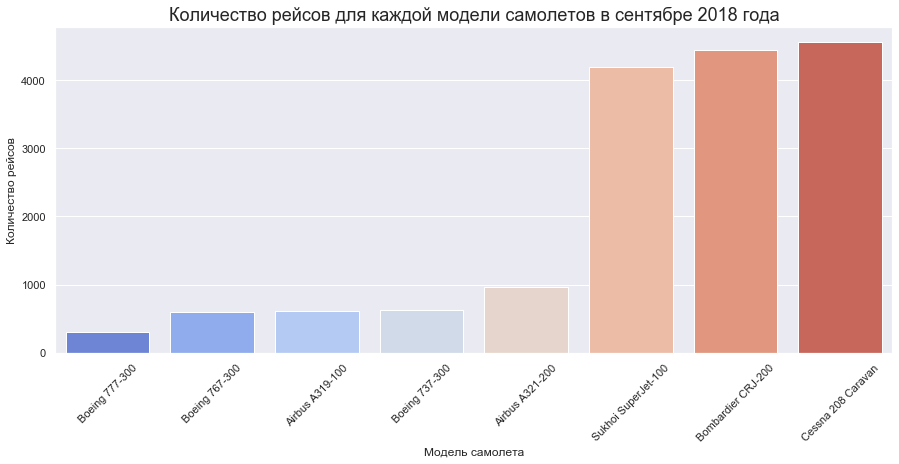

In [42]:
df_aircrafts_sorted = df_aircrafts.sort_values(by='flights_amount')

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df_aircrafts_sorted.model, y=df_aircrafts_sorted.flights_amount, 
            data=df_aircrafts_sorted.sort_values(by='flights_amount'), 
            palette='coolwarm')
ax.set_title('Количество рейсов для каждой модели самолетов в сентябре 2018 года', fontdict={'fontsize': 18})
plt.xticks(rotation=45)
plt.xlabel('Модель самолета')
plt.ylabel('Количество рейсов');

Круговая диаграмма модели самолётов и количество рейсов

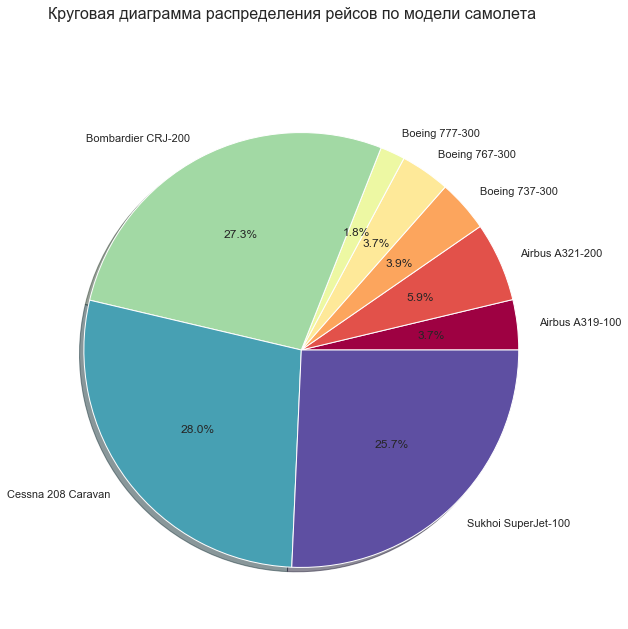

In [68]:
plt.figure(figsize=(10,10))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.pie(df_aircrafts.flights_amount, labels=df_aircrafts.model, autopct='%.1f%%', shadow=True, colors=colors)
plt.suptitle('Круговая диаграмма распределения рейсов по модели самолета', fontsize=16);

Из графиков видно, что 3 модели самолета(Bombardier CRJ-200, Cessna 208 Caravan	и Sukhoi SuperJet-100) выполняют значительно больше других рейсов. Примерно 80% всей рейсов. В целом равное по 3 лидерам распределение, модели Airbus и Boeing не использовались так часто в сентябре 2018г.	
Лидируют самолеты небольшой вместимости, летающие на короткие расстояния. Поэтому логично, что рейсов на них совершается больше.

Отсортируем **df_cities** среднему количеству рейсов в день

In [9]:
df_cities.sort_values(by='average_flights', ascending=False, inplace=True)

График среднего количество рейсов в день по всем городам

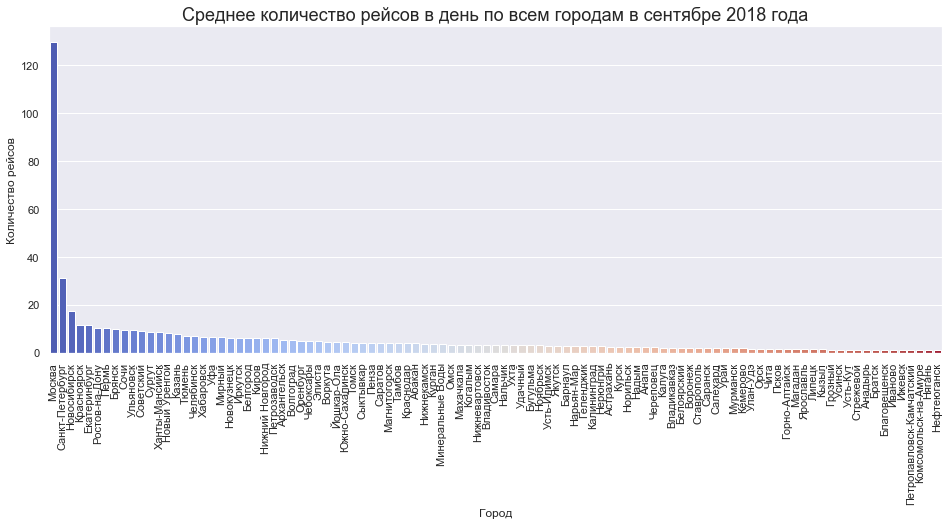

In [62]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=df_cities.average_flights, x=df_cities.city, 
            data=df_aircrafts_sorted.sort_values(by='flights_amount'), 
            palette='coolwarm')
ax.set_title('Среднее количество рейсов в день по всем городам в сентябре 2018 года', fontdict={'fontsize': 18})
plt.xticks(rotation=90)
plt.xlabel('Город')
plt.ylabel('Количество рейсов');

По графику можно сказать, что Москва имеет самое большое число средних рейсов в день. На втором месте Санк-Петербург, трейтий - Новосибирск и т.д. 

График топ-10 городов по количеству рейсов

Округлим до 1 знака после запятой:

In [57]:
top_10_cities['average_flights'] = top_10_cities['average_flights'].apply(lambda x: round(x, 1))

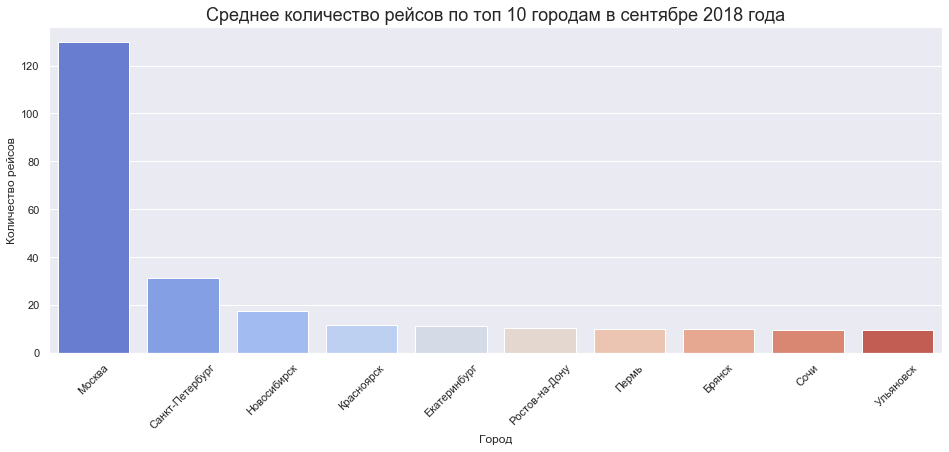

In [64]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=top_10_cities.average_flights, x=top_10_cities.city, 
            data=df_aircrafts_sorted.sort_values(by='flights_amount'), 
            palette='coolwarm')
ax.set_title('Среднее количество рейсов по топ 10 городам в сентябре 2018 года', fontdict={'fontsize': 18})
plt.xticks(rotation=45)
plt.xlabel('Город')
plt.ylabel('Количество рейсов');

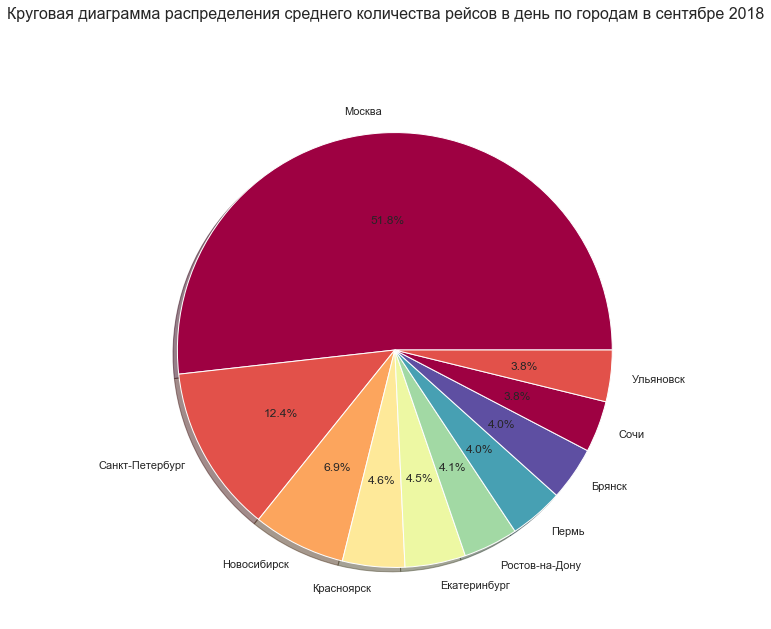

In [67]:
plt.figure(figsize=(10,10))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.pie(top_10_cities.average_flights, labels=top_10_cities.city, autopct='%.1f%%', shadow=True, colors=colors)
plt.suptitle('Круговая диаграмма распределения среднего количества рейсов в день по городам в сентябре 2018', fontsize=16);

Большую часть этих городов составляют города миллионники: Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Ростов-на-Дону, Пермь, Красноярск. Так как информация о перелетах собрана за сентябрь, то в лидеры попадает курортный город Сочи.

### Выводы по главе 1:

> - Самые популярные модели самолета Bombardier CRJ-200, Cessna 208 Caravan	и Sukhoi SuperJet-100. Выполняли значительно больше других рейсов. Примерно 80% всей рейсов. Модели Airbus и Boeing менее использовались авиакомпанией в сентябре 2018г.
- В распределении по количеству рейсов с огромным преимуществом лидирует Москва. Это объясняется тем, что город столица, культурный и финансовый центр, и самый большой по численности населения город России.

## Глава 2. Проверка гипотезы

Выведем таблицу с фестивалями и информацию о таблице

In [13]:
df_festivals = pd.read_csv('/datasets/query_last.csv')
first_view(df_festivals)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
week_number      10 non-null int64
ticket_amount    10 non-null int64
festival_week    3 non-null float64
festival_name    3 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes
None


,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Всего 10 недель и, когда фестивалей не было, имеем пропуски в столбцах **festival_week** и **festival_name**

Разобъем таблицу на 2: когда фестивали были **in_festival** и когда нет **no_festival**

In [14]:
festival_names = ['Park Live', 'Пикник Афиши', 'Видфест']

In [15]:
in_festival = df_festivals.query('festival_name in @festival_names')
in_festival

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
6,36,51386,36.0,Видфест


In [16]:
no_festival = df_festivals.query('festival_name not in @festival_names')
no_festival

,week_number,ticket_amount,festival_week,festival_name
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Посчитаем среднее количество билетов в недели фестивалей:

In [17]:
in_festival['ticket_amount'].mean()

48662.666666666664

 и без фестивалей:

In [18]:
no_festival['ticket_amount'].mean()

51530.857142857145

### Гипотеза: Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время

Сформируем нулевую гипотезу H₀ - "Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время". Тогда альтернативная гипотеза H₁ формирует следующие утверждение: "Средний спрос на билеты во время фестивалей  отличается от среднего спроса на билеты в обычное время"

Воспользуемся t-критерием Стьюдента. Требование нормальности распределения данных является необходимым для точного t-теста. Однако, даже при других распределениях данных возможно использование t-статистики. 

In [19]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(in_festival['ticket_amount'], no_festival['ticket_amount'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.377432493172683
Не получилось отвергнуть нулевую гипотезу


Полученное p-значение не позволяет отвергнуть нулевую гипотезу и говорит о том, что "Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время". С вероятностью в 37,7% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними спроса в обычные время и время фестивалей.

### Выводы по главе 2:

> Проверка гипотезы не позволяет отвергнуть нулевую гипотезу, что cредний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время, что предполагает такое же распределение в генеральной совокупности.

## Глава 3. Общий вывод

**Анализ данных показал:**
- Самые популярные модели самолета Bombardier CRJ-200, Cessna 208 Caravan и Sukhoi SuperJet-100. Выполняли значительно больше других рейсов. Примерно 80% всей рейсов. Модели Airbus и Boeing менее использовались авиакомпанией в сентябре 2018г.
- В распределении по количеству рейсов с огромным преимуществом лидирует Москва. Это объясняется тем, что город столица, культурный и финансовый центр, и самый большой по численности населения город России.  

**Проверка гипотезы показала:**
- Средний спрос на билеты во время фестивалей, вероятнее всего, не отличается от среднего спроса на билеты в обычное время, что предполагает такое же распределение в генеральной совокупности.  

**Наличие фестивалей, скорее, не влияет на продажи билетов авиакомпании. Вероятно, это связано с тем, что фестивали посещают люди, проживающее в городе фестиваля и/или рядом с ним, поэтому не пользуются самолетами как транспортным средством чтобы попасть на мероприятие. Исключения есть, но не настолько, чтобы быть значимыми для авиакомпаии в плане увелечения продаж билетов.**